In [ ]:
#nltk.download()

In [1]:
import os
import nltk
import json
import pickle
import re
import string
import pandas as pd
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

import preprocess
from lemma import LemmatizationWithPOSTagger

from utils import bm25okapi_search, search

 # Evaluate Lemmatizer on self-composed corpus


In [2]:
# Load  self_composed corpus
with open(os.path.join("corpus.txt"), 'r') as file:
    lines=file.read()
corpus=lines.split('\n')

In [95]:
len(corpus)

40

In [96]:
#Load grouth-true lemmatize of corpus
with open(os.path.join("target.txt"), 'r') as file:
    docs=file.read()
docs=[doc.split('\n') for doc in docs.split('\n\n')]

In [97]:
# Create lemmatization dictionary from the Corpus grouth-true
dict={}
tags_gt=[]
for doc in docs:
    tags=[]
    for line in doc:
        parts = line.split("=")
        word = parts[0].strip().lower()
        if word in string.punctuation and word != "'":
            continue
        form=parts[1].split("+")
        if len(form) <2:
            print(line)
        lemma= form[0].strip().lower()
        tag= form[1].strip().upper()
        if word in dict:
            dict[word][tag]=lemma
        else:
            dict[word]={tag:lemma}
        tags.append((word,tag))
    tags_gt.append(tags)
    #dicts.append(dict)

In [98]:
#calculate dictionary size
dict_size=0
for word in dict.items():
    dict_size+=len(word[1])

In [99]:
print('kích thước của dictionary xây dựng từ tập corpus được soạn:',dict_size)

kích thước của dictionary xây dựng từ tập corpus được soạn: 325


In [100]:
#Preprocess: -Return to Lowercase, unicode standardization, remove whitespaces
pr=preprocess.Preprocessing()
def pipeline(preprocess, str):
    str = preprocess.text_lowercase(str)
    str= preprocess.convert_unicode(str)
    str= preprocess.remove_whitespace(str)
    return str

In [101]:
corpus_preprocessed= [pipeline(pr,str) for str in corpus]
#Tokenize using the nltk library and remove tokens that are punctuation
corpus_tokens= [[token for token in word_tokenize(sent) if str(token) not in string.punctuation or str(token) == "'"] for sent in corpus_preprocessed]

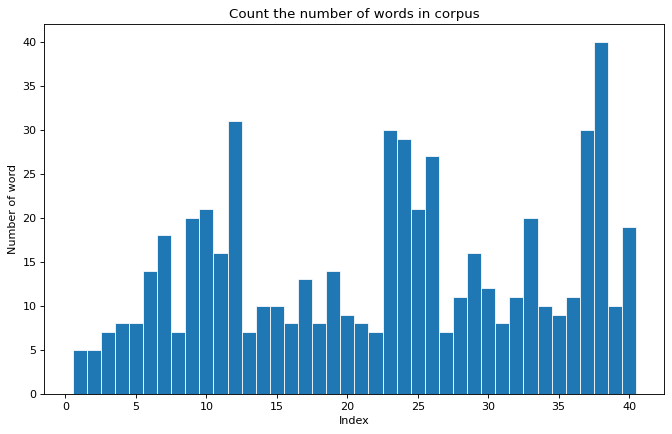

Total word in corpus:  575
longest sentence has 40 words
Shortest sentence has 5 words


In [102]:
numbers = []
for tokens in corpus_tokens:
    numbers.append(len(tokens))
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
ax.set_title('Count the number of words in corpus')
ax.set_ylabel('Number of word')
ax.set_xlabel('Index')
x = np.arange(1,len(corpus)+1)
y=np.array(numbers)
ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)
plt.show()
print("Total word in corpus: ",sum(numbers))
print(f"longest sentence has {max(numbers)} words")
print(f"Shortest sentence has {min(numbers)} words")

In [103]:
lemma= LemmatizationWithPOSTagger(use_nltk_lemma= False)
lemma_corpus, pos_tag= lemma.lemmatize(corpus_tokens, tokenizer='No_tokenize', return_pos=True)
lemma_tokens= [sent.split() for sent in lemma_corpus]

In [109]:
not_exist=0
accuracy_scores_lemma=[]
accuracy_scores_pos_tag=[]
count=[]
for i in range(len(corpus)):
    TP= 0
    TN=0
    FP=0
    FN=0
    
    for word, lemma, tag, tag_gt in zip(corpus_tokens[i],lemma_tokens[i], pos_tag[i], tags_gt[i]):
        if word not in dict:
            not_exist+=1
            continue
        #kiểm tra số lượng từ bị gán sai tag
        
        if tag[1] != tag_gt[1]:
            #print(corpus[i])
            #print(word, tag, tag_gt)
            #sai tag nhưng từ vẫn được khôi phục về từ gốc đúng(True Negative)           
            if lemma == dict[word][tag_gt[1]]:
                TN+=1
                #print(dict[word][tag_gt[1]], tag[1], tag_gt[1], lemma)
            else:
                #sai tag, sai lemma (False Negative)
                FN+=1
                #print(dict[word][tag_gt[1]], tag[1], tag_gt[1], lemma)
            continue
            
        if dict[word][tag[1]] == lemma: #đúng tag đúng lemma (True Positive)
            TP+=1
        else: #Đúng tag sai lemma (FP)
            FP+=1
            print(tag_gt, dict[word][tag[1]], lemma)
            pass
    count.append([TP,TN,FP,FN])
    accuracy_scores_lemma.append((TP+TN)/ len(corpus_tokens[i]))
    accuracy_scores_pos_tag.append((TP+FP)/len(corpus_tokens[i]))

("'m", 'VBP') be 'm
("'ll", 'MD') will 'll
("'s", 'VBZ') be 's
('gon', 'VBG') go gon
("'ve", 'VBP') have 've
('got', 'VBN') get got
("n't", 'RB') not n't
("'cause", 'IN') because 'cause
('those', 'DT') that those
("n't", 'RB') not n't
("'ll", 'MD') will 'll
("n't", 'RB') not n't
('these', 'DT') this these
("'d", 'MD') will 'd
("'m", 'VBP') be 'm
("'ve", 'VBP') have 've
("'s", 'VBZ') be 's
('known', 'VBN') know known
('would', 'MD') will would
('people', 'NNS') people person
('these', 'DT') this these
('people', 'NNS') people person
('would', 'MD') will would
('best', 'JJS') best good
('these', 'DT') this these
('these', 'DT') this these


In [110]:
mean_accuracy_lemma=np.mean(accuracy_scores_lemma)
mean_accuracy_pos_tag=np.mean(accuracy_scores_pos_tag)

In [111]:
print('Mean Accuracy khi thực hiện Lemma trên bộ ngữ liệu: ', mean_accuracy_lemma)
print('Mean Accuracy khi thực hiện POS_tag trên bộ ngữ liệu: ', mean_accuracy_pos_tag)

Mean Accuracy khi thực hiện Lemma trên bộ ngữ liệu:  0.9225317606454176
Mean Accuracy khi thực hiện POS_tag trên bộ ngữ liệu:  0.8978456678168163


In [112]:
print('số từ không xuất hiện trong tập từ điển: ',not_exist)

số từ không xuất hiện trong tập từ điển:  0


In [113]:
print('Tổng số từ được dự đoán đúng tag và đưa về từ gốc đúng: ',np.sum(count,axis=0)[0])
print('Tổng số từ được dự đoán sai tag nhưng đưa về từ gốc đúng: ',np.sum(count,axis=0)[1])

print('Tổng số từ được dự đoán đúng tag nhưng đưa về từ gốc sai: ',np.sum(count,axis=0)[2])

print('Tổng số từ được dự đoán sai tag và đưa về từ gốc sai: ',np.sum(count,axis=0)[3])

Tổng số từ được dự đoán đúng tag và đưa về từ gốc đúng:  503
Tổng số từ được dự đoán sai tag nhưng đưa về từ gốc đúng:  38
Tổng số từ được dự đoán đúng tag nhưng đưa về từ gốc sai:  26
Tổng số từ được dự đoán sai tag và đưa về từ gốc sai:  6


In [114]:
nltk_lemma= LemmatizationWithPOSTagger(use_nltk_lemma= True)
nltk_lemma_corpus, nltk_pos_tag= nltk_lemma.lemmatize(corpus_tokens, tokenizer='No_tokenize', return_pos=True)

In [115]:
nltk_lemma_tokens= [sent.split() for sent in nltk_lemma_corpus]

In [116]:
not_exist=0
accuracy_scores_lemma=[]
accuracy_scores_pos_tag=[]
count=[]
for i in range(len(corpus)):
    TP= 0
    TN=0
    FP=0
    FN=0
    
    for word, lemma, tag, tag_gt in zip(corpus_tokens[i],nltk_lemma_tokens[i], nltk_pos_tag[i], tags_gt[i]):
        if word not in dict:
            not_exist+=1
            continue
        #kiểm tra số lượng từ bị gán sai tag
        
        if tag[1] != tag_gt[1]:
            #print(corpus[i])
            #print(word, tag, tag_gt)
            #sai tag nhưng từ vẫn được khôi phục về từ gốc đúng(True Negative)           
            if lemma == dict[word][tag_gt[1]]:
                TN+=1
                #print(dict[word][tag_gt[1]], tag[1], tag_gt[1], lemma)
            else:
                #sai tag, sai lemma (False Negative)
                FN+=1
                #print(dict[word][tag_gt[1]], tag[1], tag_gt[1], lemma)
            continue
            
        if dict[word][tag[1]] == lemma: #đúng tag đúng lemma (True Positive)
            TP+=1
        else: #Đúng tag sai lemma (FP)
            FP+=1
            print(tag_gt, dict[word][tag[1]], lemma)
            pass
    count.append([TP,TN,FP,FN])
    accuracy_scores_lemma.append((TP+TN)/ len(corpus_tokens[i]))
    accuracy_scores_pos_tag.append((TP+FP)/len(corpus_tokens[i]))

("'m", 'VBP') be 'm
("'ll", 'MD') will 'll
("'s", 'VBZ') be 's
('gon', 'VBG') go gon
("'ve", 'VBP') have 've
("n't", 'RB') not n't
("'cause", 'IN') because 'cause
('those', 'DT') that those
("n't", 'RB') not n't
("'ll", 'MD') will 'll
("n't", 'RB') not n't
('these', 'DT') this these
("'d", 'MD') will 'd
("'m", 'VBP') be 'm
("'ve", 'VBP') have 've
("'s", 'VBZ') be 's
('would', 'MD') will would
('these', 'DT') this these
('as', 'IN') as a
('would', 'MD') will would
('these', 'DT') this these
('these', 'DT') this these


In [118]:
mean_accuracy_lemma=np.mean(accuracy_scores_lemma)
mean_accuracy_pos_tag=np.mean(accuracy_scores_pos_tag)

In [119]:
print('Mean Accuracy khi thực hiện Lemma trên bộ ngữ liệu: ', mean_accuracy_lemma)
print('Mean Accuracy khi thực hiện POS_tag trên bộ ngữ liệu: ', mean_accuracy_pos_tag)

Mean Accuracy khi thực hiện Lemma trên bộ ngữ liệu:  0.9332171863308434
Mean Accuracy khi thực hiện POS_tag trên bộ ngữ liệu:  0.8978456678168163


In [164]:
print('số từ không xuất hiện trong tập từ điển: ',not_exist)

số từ không xuất hiện trong tập từ điển:  0


In [165]:
print('Tổng số từ được dự đoán đúng tag và đưa về từ gốc đúng: ',np.sum(count,axis=0)[0])
print('Tổng số từ được dự đoán sai tag nhưng đưa về từ gốc đúng: ',np.sum(count,axis=0)[1])

print('Tổng số từ được dự đoán đúng tag nhưng đưa về từ gốc sai: ',np.sum(count,axis=0)[2])

print('Tổng số từ được dự đoán sai tag và đưa về từ gốc sai: ',np.sum(count,axis=0)[3])

Tổng số từ được dự đoán đúng tag và đưa về từ gốc đúng:  507
Tổng số từ được dự đoán sai tag nhưng đưa về từ gốc đúng:  39
Tổng số từ được dự đoán đúng tag nhưng đưa về từ gốc sai:  22
Tổng số từ được dự đoán sai tag và đưa về từ gốc sai:  5


# PREPROCESS MUSIC DATA

In [4]:
features=['title', 'id', 'release_date', 'lyrics']

In [5]:
df=pd.DataFrame()
for dirname, _, filenames in os.walk('data\json files'):
    for filename in filenames:
        with open(os.path.join(dirname, filename)) as f:
            aux = json.load(f)
            df_tmp=pd.DataFrame()
            Artist= np.full((len(aux['songs'])), aux['name'])
            df_tmp['artist']=Artist
            for f in features:
                col=[song[f] for song in aux['songs']]
                df_tmp[f]=col
            df=pd.concat([df,df_tmp]).reset_index(drop=True)

In [6]:
#filter other versions of the song and keep the original song
tmp=[]
tags=['remix', 'mashup','traduction','snippet','translation' , 'unreleased', 'concept', 'leak', 'extended','live','club', 'acoustic',' version', ' ver', 'demo', 'reprise', 'copy', 'mix','edit', 'dub', 'studio', 'record', 'video', 'original', 'radio', 'quotes','reimagined', 'clean', 'demo']
for title in df['title']:
    for tag in tags:
        if re.search(f'\[(.*?){tag}(.*?)\]' ,title.lower()) != None:
            tmp.append(title)
        if re.search(f'\((.*?){tag}(.*?)\)' ,title.lower()) != None:
            tmp.append(title)
        if re.search(f"\ {tag}", title.lower()) != None:
            tmp.append(title)

In [7]:
#filter other versions of the song and keep the original song
tmp=[]
tags=['remix', 'mashup','traduction','snippet','translation' , 'unreleased', 'concept', 'leak', 'extended','live','club', 'acoustic',' version', ' ver', 'demo', 'reprise', 'copy', 'mix','edit', 'dub', 'studio', 'record', 'video', 'original', 'radio', 'quotes','reimagined', 'clean', 'demo']
for title in df['title']:
    for tag in tags:
        if re.search(f'\[(.*?){tag}(.*?)\]' ,title.lower()) != None:
            tmp.append(title)
        if re.search(f'\((.*?){tag}(.*?)\)' ,title.lower()) != None:
            tmp.append(title)
        if re.search(f"\ {tag}", title.lower()) != None:
            tmp.append(title)
for title in tmp:
    df= df[df.title != title].reset_index(drop=True)

In [8]:
for f in features:
    print("number null value of {}: ".format(f),sum(df[f].isnull()))
    
#delete songs which have null lyrics
df.dropna(subset = ["lyrics"], inplace=True)

number null value of title:  0
number null value of id:  0
number null value of release_date:  1338
number null value of lyrics:  7


In [9]:
#filter out songs with invalid lyrics
tmp=[]
for idx,lyric in zip(df.id, df.lyrics):
    if (len(lyric.split("\n"))<6 and re.search('\[(.*?)\]', lyric)==None) or len(lyric)<100: 
        tmp.append(idx)
for i in tmp:
    df=df[df.id!=i]
df=df.reset_index(drop=True)

In [10]:
df

,artist,title,id,release_date,lyrics
0,Ariana Grande,"​thank u, next",4063065,2018-11-03,[Verse 1]\nThought I'd end up with Sean\nBut h...
1,Ariana Grande,7 rings,4067762,2019-01-18,"[Verse 1]\nYeah, breakfast at Tiffany's and bo..."
2,Ariana Grande,​God is a woman,3681280,2018-07-13,"[Chorus]\nYou, you love it how I move you\nYou..."
3,Ariana Grande,Side To Side,2457495,2016-05-20,[Intro: Ariana Grande & Nicki Minaj]\nI've bee...
4,Ariana Grande,​​no tears left to cry,3649172,2018-04-20,"[Intro]\nRight now, I'm in a state of mind\nI ..."
...,...,...,...,...,...
3739,Taylor Swift,"Taylor Swift - no body, no crime (Traducción a...",6274728,2020-12-11,[Intro: HAIM]\nÉl lo hizo\nÉl lo hizo\n\n[Vers...
3740,Taylor Swift,Welcome Back Grunwald,6226864,None,Turn WYCD on\nYou're\nOn your Grunwald\nBack f...
3741,Taylor Swift,Tolerate it (Polskie Tłumaczenie),6315848,2020-12-11,[Zwrotka 1]\nSiedzę i patrzę jak czytasz z gło...
3742,Taylor Swift,Find you,6209316,None,Trying just like they say\nJust taking the ste...


In [11]:
#write to csv file
df.to_csv('music_data.csv', encoding="utf-8", index=False)

In [12]:
#df=pd.read_csv('music_data.csv', encoding="utf-8")

# Preprocessing

In [13]:
#Select the option by adding one of the following tags to the Preprocessing Pipeline
##For normalise text: ['WordNetLemmatizer', 'PorterStemmer', 'DIY_lemmatizer']
##For remove stop_word: ['remove_stopword']
##or 
clean= preprocess.Preprocessing(Pipeline=['PorterStemmer'])

In [14]:
#preprocess lyric of the data song
from tqdm import tqdm
lyrics=np.array([])
for lyric in tqdm(df.lyrics):
    lyrics=np.append(lyrics,clean.Preprocess(lyric))

100%|██████████████████████████████████████████████████████████████████████████████| 3744/3744 [05:11<00:00, 12.03it/s]


In [15]:
tokenize_lyric=[]
from tqdm import tqdm
for lyric in tqdm(lyrics):
    tokenize_lyric.append(lyric.split())


100%|████████████████████████████████████████████████████████████████████████████| 3744/3744 [00:00<00:00, 8808.92it/s]


In [16]:
for i in range(len(df.id)):
    tokenize_lyric[i].append(f"-->{df.id[i]}")

In [17]:
from rank_bm25 import BM25Okapi, BM25Plus

In [18]:
bm25 = BM25Okapi(tokenize_lyric)

In [19]:
#Search

In [46]:
corpus= "I hear your voice in my sleep at night\nHard to resist temptation"
corpus=corpus.replace('...',' ')
corpus=clean.Preprocess(corpus)
corpus=[corpus.split(" ")]

In [47]:
corpus

[['i',
  'hear',
  'your',
  'voic',
  'in',
  'my',
  'sleep',
  'at',
  'night',
  'hard',
  'to',
  'resist',
  'temptat']]

In [48]:
rank=bm25okapi_search(corpus[0], bm25, tokenize_lyric, n_results= 5)

In [49]:
rank

[452357, 197288, 191026, 4459561, 5794073]

In [50]:
df[df.id.isin(rank)].reset_index(drop=True)

,artist,title,id,release_date,lyrics
0,Maroon 5,Maps,452357,2014-06-16,[Verse 1]\nI miss the taste of a sweeter life\...
1,Maroon 5,Get Back In My Life,191026,NaN,[Verse 1]\nYou are relentless\nI am defenseles...
2,Rihanna,Sell Me Candy,197288,2007-05-31,[Verse 1]\nSell me candy like it’s summer when...
3,Rihanna,Hole in My Head,4459561,2009-11-23,[Intro: Justin Timberlake]\nLet go!\nYou got a...
4,Taylor Swift,​the 1,5794073,2020-07-24,"[Verse 1]\nI'm doing good, I'm on some new shi..."


In [ ]:
#Eval

In [51]:
test_df=pd.read_csv('test.csv')
test_df['qid']=test_df.index +1

In [52]:
test_df

,corpus,id,artist,title,qid
0,"Now I listn and laugh... Ad for tht, I say",4063065,Ariana Grande,"​thank u, next",1
1,"I see it, I like it, I want it, I got it",4067762,Ariana Grande,7 rings,2
2,I keep on flourish...feelig that you can't figh,3681280,Ariana Grande,​God is a woman,3
3,"You take my cares away...over-complicate,... M...",3681287,Ariana Grande,​​breathin,4
4,"Painted a picture...They see demon, I see angel",4114857,Ariana Grande,​in my head,5
...,...,...,...,...,...
95,pink and purple in the sky,4705721,Katy Perry,Harleys In Hawaii,96
96,Open up your heart,239156,Katy Perry,Unconditionally,97
97,"Yeah, I am born again...I'm wide awake",83607,Katy Perry,Wide Awake,98
98,Silver Lake... rose,239162,Katy Perry,This is How We Do,99


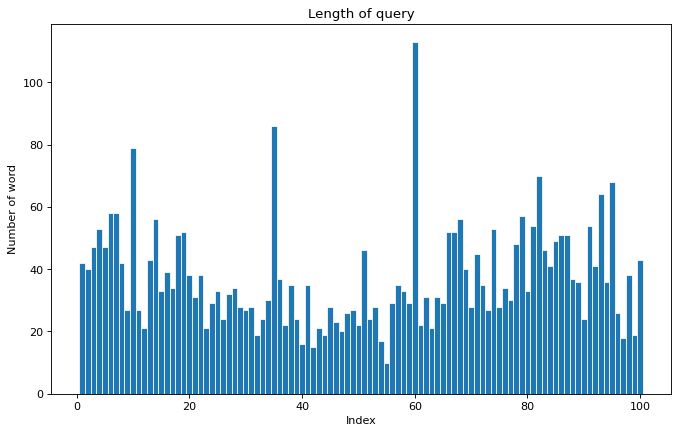

longest query has 113 words
Shortest query has 10 words


In [54]:
numbers = []
for tokens in test_df.iloc():
    numbers.append(len(tokens['corpus']))
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
ax.set_title('Length of query')
ax.set_ylabel('Number of word')
ax.set_xlabel('Index')
x = np.arange(1,100+1)
y=np.array(numbers)
ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)
plt.show()
print(f"longest query has {max(numbers)} words")
print(f"Shortest query has {min(numbers)} words")

In [55]:
query_token=[]
for _, row in test_df.iterrows(): 
    query=row['corpus'].replace('...',' ')
    query=clean.Preprocess(query)
    query=query.split(" ")
    query_token.append(query)

test_df['query_token']= query_token

In [56]:
test_df

,corpus,id,artist,title,qid,query_token
0,"Now I listn and laugh... Ad for tht, I say",4063065,Ariana Grande,"​thank u, next",1,"[now, i, listn, and, laugh, ad, for, tht, i, say]"
1,"I see it, I like it, I want it, I got it",4067762,Ariana Grande,7 rings,2,"[i, see, it, i, like, it, i, want, it, i, got,..."
2,I keep on flourish...feelig that you can't figh,3681280,Ariana Grande,​God is a woman,3,"[i, keep, on, flourish, feelig, that, you, can..."
3,"You take my cares away...over-complicate,... M...",3681287,Ariana Grande,​​breathin,4,"[you, take, my, care, away, overcomplicate, me..."
4,"Painted a picture...They see demon, I see angel",4114857,Ariana Grande,​in my head,5,"[paint, a, pictur, they, see, demon, i, see, a..."
...,...,...,...,...,...,...
95,pink and purple in the sky,4705721,Katy Perry,Harleys In Hawaii,96,"[pink, and, purpl, in, the, sky]"
96,Open up your heart,239156,Katy Perry,Unconditionally,97,"[open, up, your, heart]"
97,"Yeah, I am born again...I'm wide awake",83607,Katy Perry,Wide Awake,98,"[yeah, i, am, born, again, i, am, wide, awak]"
98,Silver Lake... rose,239162,Katy Perry,This is How We Do,99,"[silver, lake, rose]"


In [57]:
top_n_rank= 10

In [58]:
search_results=search(test_df, bm25, tokenize_lyric, top_n_rank)

In [59]:
search_results[11:21]

,rank,id,qid
11,2,80387,2
12,3,1605996,2
13,4,3649172,2
14,5,5180453,2
15,6,50605,2
16,7,2953814,2
17,8,183160,2
18,9,152217,2
19,10,6403503,2
20,1,3681280,3


In [60]:
judgments= test_df[['qid','id']]
judgments['relevancy grade']= 1

C:\Users\hoang\AppData\Local\Temp\ipykernel_23508\2191158720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  judgments['relevancy grade']= 1


In [61]:
judgments

,qid,id,relevancy grade
0,1,4063065,1
1,2,4067762,1
2,3,3681280,1
3,4,3681287,1
4,5,4114857,1
...,...,...,...
95,96,4705721,1
96,97,239156,1
97,98,83607,1
98,99,239162,1


In [62]:
labeled_search_results = search_results.merge(judgments, how='left', on=['qid', 'id']).fillna(0)
labeled_search_results.head(20)

,rank,id,qid,relevancy grade
0,1,6260164,1,0.0
1,2,66564,1,0.0
2,3,57183,1,0.0
3,4,256666,1,0.0
4,5,2046,1,0.0
5,6,4695769,1,0.0
6,7,186987,1,0.0
7,8,3776346,1,0.0
8,9,79649,1,0.0
9,10,1759574,1,0.0


In [63]:
relevances_rank = labeled_search_results.groupby(['qid', 'relevancy grade'])['rank'].min()

In [64]:
relevances_rank

qid  relevancy grade
1    0.0                1
2    0.0                2
     1.0                1
3    0.0                2
     1.0                1
                       ..
98   1.0                1
99   0.0                1
     1.0                6
100  0.0                2
     1.0                1
Name: rank, Length: 190, dtype: int64

In [65]:
#Calculate evaluate Score as Mean Reciprocal Rank (MRR) metric
ranks = relevances_rank.loc[:, 1]
reciprocal_ranks = 1 / (ranks)
MRR= reciprocal_ranks.sum()/len(judgments)

In [66]:
rank, count= np.unique(ranks, return_counts= True)
counts_rank= np.zeros(top_n_rank+1)
for (i, num) in zip(rank, count):
    counts_rank[i]= num

#Rank 0 is prediction outside the top n
counts_rank[0]= len(test_df)- count.sum()

Mean Reciprocal Rank score:  0.7647619047619049


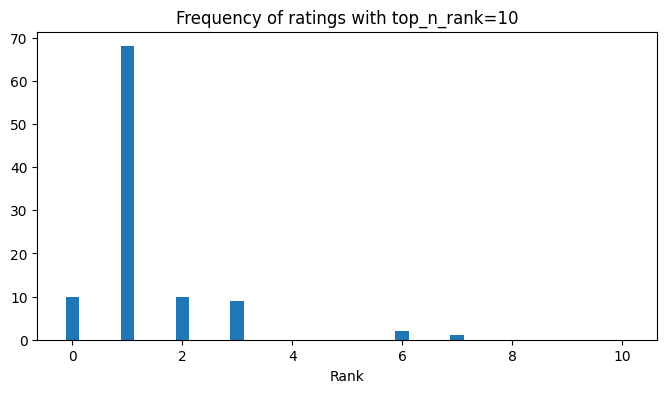

In [67]:
fig =plt.figure(figsize=(8,4))
barWidth=0.25
plt.title(f"Frequency of ratings with top_n_rank={top_n_rank}")
plt.xlabel("Rank")

plt.bar(np.arange(0,top_n_rank+1),counts_rank, width=barWidth)

print("Mean Reciprocal Rank score: ", MRR)